### note: run deidentification on dup image data

In [1]:
# https://stanfordmlgroup.github.io/competitions/chexpert/

### imports

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.vision import *
import fastai; fastai.__version__

'1.0.55.dev0'

In [4]:
data_path = Path("../../data/siim_acr_pneu/"); data_path.ls()

[PosixPath('../../data/siim_acr_pneu/train'),
 PosixPath('../../data/siim_acr_pneu/clas_df.csv'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-test'),
 PosixPath('../../data/siim_acr_pneu/models'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-train'),
 PosixPath('../../data/siim_acr_pneu/train-rle.csv'),
 PosixPath('../../data/siim_acr_pneu/seg_df.csv'),
 PosixPath('../../data/siim_acr_pneu/learn'),
 PosixPath('../../data/siim_acr_pneu/test')]

In [5]:
torch.cuda.set_device(2)

In [6]:
chexpert_stats = [tensor([0.5381, 0.5381, 0.5381]), tensor([0.2820, 0.2820, 0.2820])]

### databunch

In [7]:
sz = 224
tfms = get_transforms()
data = (ImageList.from_csv(data_path, 'clas_df.csv', folder=f'train/images_{sz}', suffix='.jpg')
        .split_by_rand_pct(0.1, seed=42)
        .label_from_df()
        .transform(tfms=tfms, size=sz) 
        .databunch()
        .normalize(chexpert_stats)
     )

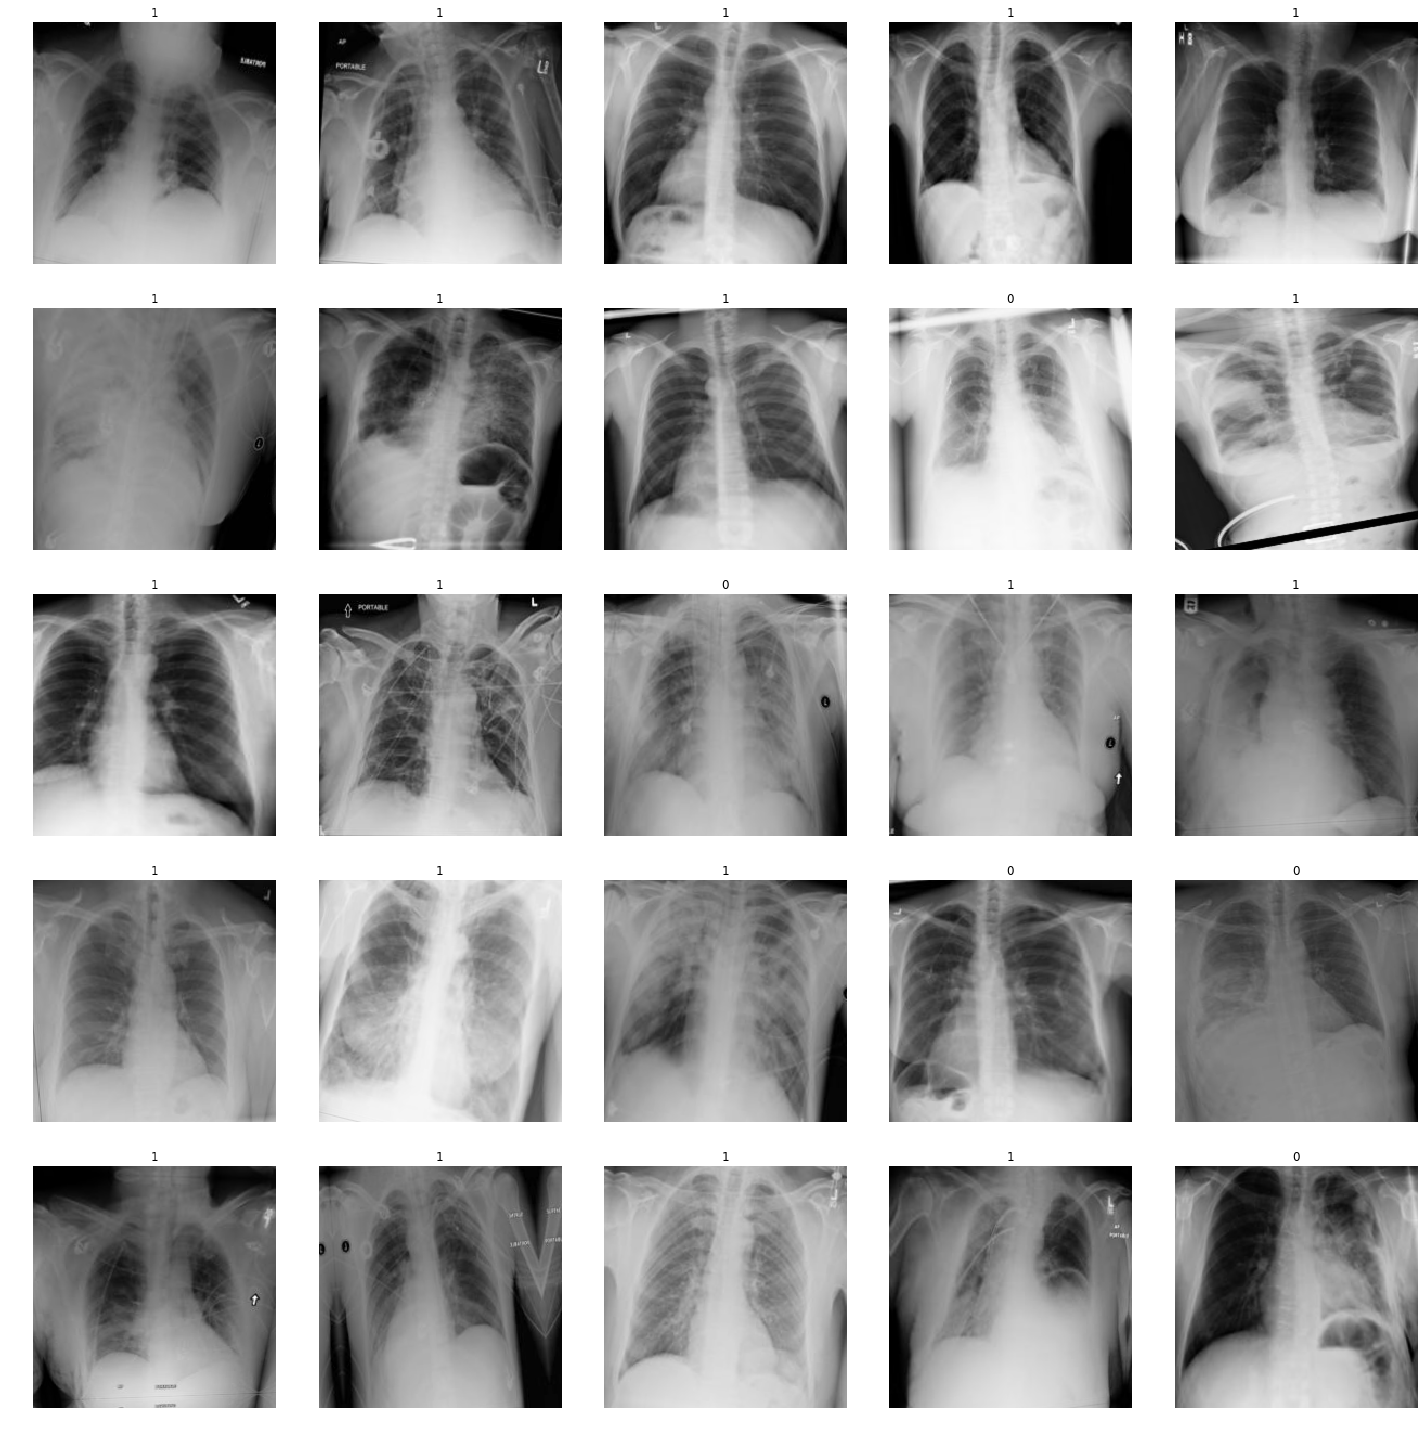

In [8]:
data.show_batch()

In [8]:
len(data.train_ds), len(data.valid_ds)

(10458, 1161)

### model

In [9]:
def _xresnet_split(m:nn.Module): return (m[6], m[8])

In [14]:
# learn = cnn_learner(data, models.resnet34, pretrained=True)
learn = Learner(data, models.xresnet34(c_out=data.c)); learn.split(_xresnet_split);

In [15]:
learn.callbacks+=[AUROC()]

In [16]:
# finetune from chexpert model
chexpert_state_dict = torch.load("../../data/chexpert/models/u-ignore-resnext34-224.pth")

In [17]:
# load state dict from chexpert model until last fully connected layer
for n, p in list(learn.model.named_parameters())[:-2]:
    p.data = chexpert_state_dict['model'][n].to(torch.device(2))

In [18]:
baseline = learn.data.valid_ds.y.items.mean(); print(f"baseline: {baseline}")

baseline: 0.7174849267872524


In [19]:
learn.freeze()

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


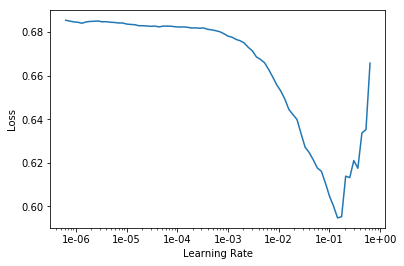

In [21]:
learn.recorder.plot()

In [22]:
learn.metrics = [accuracy, AUROC()]

In [23]:
lr = 2e-2

In [24]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.391296,0.385466,0.819983,0.885138,00:23
1,0.374001,0.424663,0.805340,0.908478,00:23
2,0.349723,0.398815,0.819121,0.914649,00:23
3,0.321623,0.346314,0.847545,0.917398,00:23
4,0.311494,0.318010,0.858742,0.921420,00:23


In [25]:
learn.freeze_to(-1)

In [26]:
learn.fit_one_cycle(5, slice(lr/2))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.302036,0.318279,0.858742,0.922024,00:23
1,0.305733,0.315610,0.852713,0.922551,00:23
2,0.299974,0.315350,0.857020,0.922478,00:23
3,0.300493,0.316415,0.861326,0.922840,00:23
4,0.303168,0.318727,0.862188,0.923027,00:23


In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(5, slice(lr/5))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.306177,0.314097,0.861326,0.924428,00:32
1,0.303550,0.319819,0.863049,0.925578,00:32
2,0.291172,0.317742,0.863049,0.925559,00:32
3,0.298035,0.312770,0.863910,0.926708,00:32
4,0.293774,0.309418,0.867356,0.926533,00:31


In [29]:
learn.fit_one_cycle(10, slice(lr/5))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.275269,0.311830,0.863049,0.926306,00:32
1,0.284085,0.309331,0.866494,0.926152,00:32
2,0.289341,0.308115,0.871662,0.925772,00:32
3,0.280770,0.320043,0.861326,0.927217,00:32
4,0.275780,0.308692,0.873385,0.927206,00:32
5,0.279300,0.317090,0.873385,0.927005,00:32
6,0.273524,0.306196,0.872524,0.927551,00:32
7,0.261039,0.313585,0.876830,0.928066,00:32
8,0.267072,0.307099,0.878553,0.928436,00:32
9,0.267833,0.310318,0.874246,0.928425,00:32


In [44]:
learn.fit_one_cycle(10, slice(lr/5))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.260490,0.306154,0.875969,0.929523,00:32
1,0.260656,0.319072,0.874246,0.928937,00:33
2,0.265300,0.314217,0.871662,0.929117,00:33
3,0.261283,0.319721,0.871662,0.928297,00:32
4,0.259943,0.304646,0.877692,0.927265,00:34
5,0.254049,0.317445,0.873385,0.926698,00:34
6,0.242822,0.308620,0.874246,0.928220,00:35
7,0.253177,0.310019,0.877692,0.929139,00:35
8,0.245280,0.308451,0.876830,0.929113,00:34
9,0.241242,0.305924,0.875969,0.929477,00:35


In [45]:
learn.fit_one_cycle(10, slice(lr/10))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.242093,0.306339,0.875108,0.929347,00:31
1,0.247644,0.315451,0.871662,0.928634,00:32
2,0.247430,0.303630,0.871662,0.928952,00:32
3,0.244766,0.308648,0.877692,0.928908,00:32
4,0.242779,0.314733,0.869940,0.928645,00:32
5,0.228917,0.315589,0.875969,0.928213,00:32
6,0.238748,0.315274,0.876830,0.928385,00:39
7,0.236399,0.311964,0.877692,0.927678,00:37
8,0.238139,0.311794,0.876830,0.928626,00:32
9,0.235010,0.315253,0.875969,0.927477,00:32


In [ ]:
learn.to_fp32()

In [30]:
# learn.save(f"clas-resnet34-{sz}")
# learn.save(f"clas-chexpert-ft-resnet34-{sz}")
learn.save(f"clas-chexpert-ft-resnext34-{sz}")

In [31]:
learn.validate(learn.data.valid_dl)

[0.3103183, tensor(0.8742), tensor(0.9284), tensor(0.9284)]

### add test

In [32]:
test = ImageList.from_folder(data_path/f'test/images_{sz}', extensions='.jpg')

In [33]:
learn.data.add_test(test)

In [35]:
# learn.load(f"clas-resnet34-{sz}");
# learn.load(f"clas-chexpert-ft-resnet34-{sz}");
learn.load(f"clas-chexpert-ft-resnext34-{sz}");

### save all learn obj

In [36]:
os.makedirs(data_path/"learn", exist_ok=True)

In [37]:
with ModelOnCPU(learn.model) as model:
#     try_save({"data":learn.data, "model":model}, data_path, f"learn/clas-chexpert-ft-resnet34-{sz}")
    try_save({"data":learn.data, "model":model}, data_path, f"learn/clas-chexpert-ft-resnext34-{sz}")

### interpret

In [38]:
from sklearn.metrics import roc_auc_score, f1_score

In [39]:
preds, targs = learn.get_preds(DatasetType.Valid)

In [40]:
roc_auc_score(targs, preds[:,1])

0.9284250285480047

In [41]:
f1_score(targs, preds[:,1]>0.3)

0.9072886297376094

In [42]:
interp = learn.interpret()

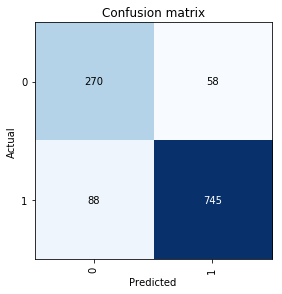

In [43]:
interp.plot_confusion_matrix()